# Exploring `build_cutouts` outputs

This jupyter notebook analyse the `build_cutout.py` **outputs**. Cutouts are returning wind, solar and run-off river relevant timeseries that are created with the Atlite tool (wind speeds, solar iradiation, etc.). We recommend going through [Atlite's notebooks](https://github.com/PyPSA/atlite/tree/master/examples) to learn more about it's fantastic capabilities.

The `pypsa-earth/Snakefile` explicitly list in the **rule** what goes into the function `build_cutouts.py` and what goes out (`networks/{cutout}.nc`). So to create the i.e. wind speed timeseries, we only need to provide shapes of the area of interest as input and automatically can create outputs.

```
if config['enable'].get('build_cutout', False):
    rule build_cutout:
        input:
            regions_onshore="resources/regions_onshore.geojson",
            regions_offshore="resources/regions_offshore.geojson"
        output: "cutouts/{cutout}.nc"
        log: "logs/build_cutout/{cutout}.log"
        benchmark: "benchmarks/build_cutout_{cutout}"
        threads: ATLITE_NPROCESSES
        resources: mem=ATLITE_NPROCESSES * 1000
        script: "scripts/build_cutout.py"
```

Before analysing the outputs of add_electricity.py check that:
- `pypsa-earth` environment (/kernel) in jupyter notebook  is active and updated
- root folder where pypsa-earth is installed is named "pypsa-earth"
- or rename the below `sets_path_to_root("<folder_name>")` accordingly

In [1]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root

sets_path_to_root("pypsa-earth-project")

This is the repository path:  /home/anas/EDF/pypsa-earth-project
Had to go 2 folder(s) up.


A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-earth` environment:

In [2]:
import atlite
import cartopy.crs as ccrs
import xarray as xr
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

## Create a cutout (takes quite a while)
If you don't have already an cutout for instance `pypsa-earth/cutouts/africa-2013-era5.nc` in your folder you need to create one (or download one through our google cloud). Note: That we only provide the cutout for whole Africa at the moment. If another regions is of interest you need to do the following:

- Go through the Atlite example: https://github.com/PyPSA/atlite/blob/master/examples/create_cutout.ipynb (as described there, we need to setup some stuff to download cutouts)
- Copy and rename the `config_default.yaml` to `config.yaml`
- Change the `config.yaml` if needed:

```
atlite:
  nprocesses: 4
  cutouts:
    africa-2013-era5:         # This can be renamed for instance mena-2013-era5
      module: era5            # dataset
      dx: 0.3                 # raster/ cutout resolution 
      dy: 0.3                 # raster/ cutout resolution
      time: ["2013", "2013"]  # weather year of interest. 2013 is default. 
```
- provide the input shapes of the **Snakefile rule** for the region of interest. Make sure that for instance `regions_onshore.geojson` contains the data of Middle-East if you want to create a cutout of this area **and** this file need to be located in `pypsa-earth/resources` according to the Snakefile rule:
```    
    input:
            regions_onshore="resources/regions_onshore.geojson",
            regions_offshore="resources/regions_offshore.geojson"
```
- execute the following command when located at `~/pypsa-earth`:
```
    snakemake -j 1 cutouts/africa-2013-era5.nc
    or
    snakemake -j 1 cutouts/mena-2013-era5.nc
```
, depending on which name you defined in the `config.yaml` **and** in the `Snakefile`

## Let's open the cutouts = weather/environment cells
Cutouts in Atlite are rasterized weather and environment cells. They are produced in the `build_cutouts.py` and lead to the output `africa-2013-era5.nc` which is stored in the `pypsa-earth/cutouts` folder. We read first the path and open then the .nc file with xarray. As you can see from the ploted content below there is quite a lot data available. All data variabes are grided (x,y) and most of them even over time. Let's have a look.

In [3]:
weather_cell_path = os.path.realpath("pypsa-earth/cutouts") + "/africa-2013-era5.nc"
weather_cell = xr.open_dataset(weather_cell_path)

In [4]:
weather_cell

<xarray.Dataset>
Dimensions:           (x: 44, y: 44, time: 8760)
Coordinates:
  * x                 (x) float64 2.1 2.4 2.7 3.0 3.3 ... 14.1 14.4 14.7 15.0
  * y                 (y) float64 1.5 1.8 2.1 2.4 2.7 ... 13.5 13.8 14.1 14.4
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon               (x) float64 ...
    lat               (y) float64 ...
Data variables: (12/13)
    height            (y, x) float32 ...
    wnd100m           (time, y, x) float32 ...
    wnd_azimuth       (time, y, x) float32 ...
    roughness         (time, y, x) float32 ...
    influx_toa        (time, y, x) float32 ...
    influx_direct     (time, y, x) float32 ...
    ...                ...
    albedo            (time, y, x) float32 ...
    solar_altitude    (time, y, x) float64 ...
    solar_azimuth     (time, y, x) float64 ...
    temperature       (time, y, x) float32 ...
    soil temperature  (time, y, x) float32 ...
    runoff            (time, y, x) float32 ...
Attributes:
    module:             era5
    prepared_features:  ['influx', 'runoff', 'temperature', 'height', 'wind']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2022-10-28 00:33:41 GMT by grib_to_netcdf-2.25.1: /op...

## Assessing the height profile

Assessing the smooth map below, you might recognise that the maximum value is 3438m. But actually the highest mountain in Africa is the Mount Kilimanjaro with an elevation of 5,895m. So what's going wrong? Nothing. As you might remember from the Atlite examples, each cutout cell is about 20 x 20km depending where you are in the world. All values in the cells are averaged therefore the 3438m instead of showing the highest mountain. 

FYI, if the underlying grided dataset is high enough, i.e. in 1x1m resolution, and we would replace in the 20x20km cutout the mean() for a max() the map below would probably show the Kilimanjaro peak.

In [5]:
print("Maximial elevation in the dataset = ", weather_cell["height"].max())

Maximial elevation in the dataset =  <xarray.DataArray 'height' ()>
array(1564.04064941)


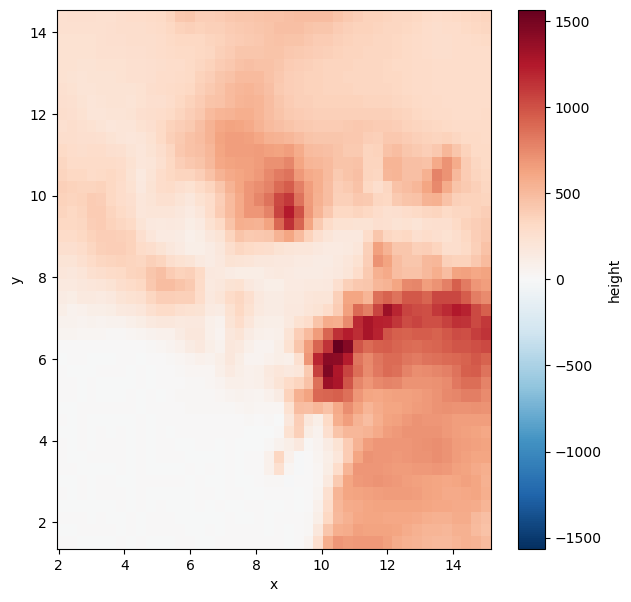

In [6]:
weather_cell["height"].plot()

## Create animation for (x,y,time) data
This works surprisingly easy with the hvplot and holomap.

- First, we create an interactive plot. We pick for that purpose the first 24 hours of the year and assess the `influx_diffuse` from the xarray variables. You can change by hand the timestamp.

- Second, we let the interactive plot convert in an animation with a cetain frames per second (fps) ratio. An fps ratio of 1 is equal to one picture in one second. 10 fps are 10 pictures in one second and therefore much faster. 

FYI, did you know that videos are nothing else then a lot of pictures? If the fps is too low we consider that as flickering. For most human eyes a smooth video is between 30 - 60 fps. https://www.healthline.com/health/human-eye-fps#how-vision-works

In [ ]:
hv.extension("matplotlib")
ds = hv.Dataset(
    weather_cell["influx_diffuse"].isel(time=range(6, 10))
)  # range 3 can be replaced by time=2
images = ds.to(hv.Image, ["x", "y"]).options(
    fig_inches=(10, 5), colorbar=True, cmap="oranges", projection=ccrs.PlateCarree()
)
# hv.help(hv.Image) #  To see full documentation

In [8]:
# images

:HoloMap   [time]
   :Overlay
      .Image.I     :Image   [x,y]   (influx_diffuse)
      .Borders.I   :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
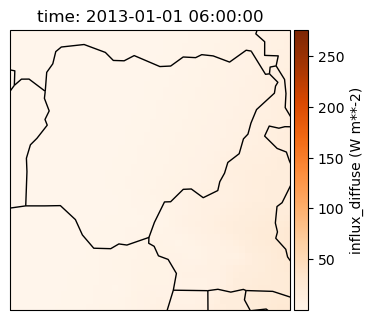
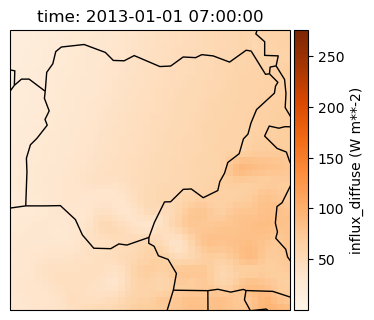
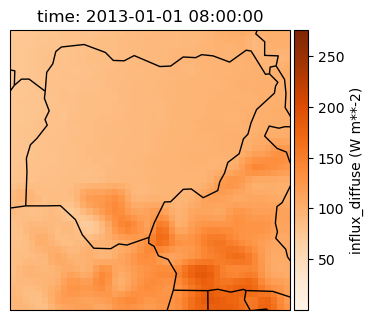
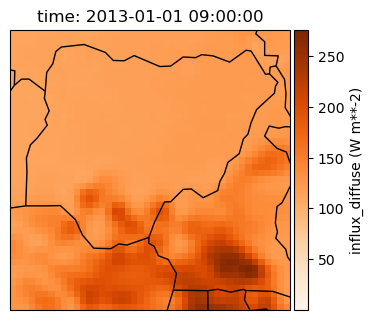
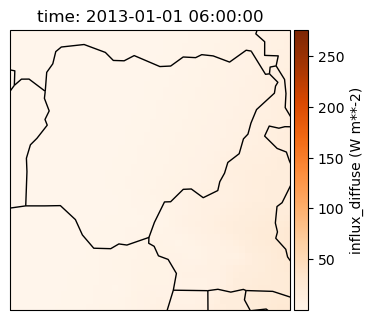

In [9]:
images * gv.feature.borders * gv.feature.coastline

In [10]:
# %%output holomap='mp4', fps=10
# images * gv.feature.borders * gv.feature.coastline

Now the interactive plots of each variable:

In [11]:
# TODO: Bug y,x axis labels are missing, y2 is cut.
# Reason for the bug is the geoviews (gv) and holoviews (hv) interaction.
# The hv plot alone had no borders/shape lines.
# We implemented gv to deal with it.

variables = [
    "wnd100m",
    "roughness",
    "influx_toa",
    "influx_direct",
    "influx_diffuse",
    "albedo",
    "temperature",
    "soil temperature",
    # "runoff",
]
color_maps = [
    "blues",
    "greys",
    "oranges",
    "oranges",
    "oranges",
    "viridis",
    "reds",
    "purples",
    # "greens",
]
i = 0

for variable in variables:
    i = i + 1
    ds = hv.Dataset(weather_cell[variable].isel(time=range(6, 30, 12)))
    images = ds.to(hv.Image, ["x", "y"]).options(
        fig_inches=(10, 5), colorbar=True, cmap=color_maps[i - 1]
    )
    # display(images * gv.feature.borders * gv.feature.coastline) # show plots in the notebook
    hv.save(images * gv.feature.borders * gv.feature.coastline, "documentation/" + variable + ".html");

### Full year animation (runs quite some time < 30min)

In [12]:
### COMMENTED IN FOR ANIMATION ###

# variables = ["wnd100m", "influx_direct", "temperature"]
# color_maps = ["blues", "oranges", "coolwarm"]
# i = 0

# for variable in variables:
#     i = i + 1
#     ds = hv.Dataset(weather_cell[variable].isel(time=range(24 * 100, 24 * 130, 1)))
#     images = ds.to(hv.Image, ["x", "y"]).options(
#         fig_inches=(10, 5), colorbar=True, cmap=color_maps[i - 1]
#     )
#     # hv.save(
#     #     images, f"{variable}_animation.mp4", fps=30
#     # )  # Changes the outputfile name automatically, fps=4 equals 1 day per second in our case

## Using Atlite we can use some plotting examples

Applied from https://atlite.readthedocs.io/en/latest/examples/plotting_with_atlite.html

In [13]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter("ignore")
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

### Create shapes for Nigeria
- use the shapereader of Cartopy to retrieve high resoluted shapes
- make a GeoSeries with the shapes

In [14]:
shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
NG = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["Nigeria"])

### Load cutout
- Will appear in the `pypsa-earth/cutouts/` after one run the pypsa-earth workflow

In [15]:
cutout_path = os.path.join(
    os.path.realpath("pypsa-earth/cutouts"), "africa-2013-era5.nc"
)
cutout = atlite.Cutout(path=cutout_path)
cutout.data

<xarray.Dataset>
Dimensions:           (x: 44, y: 44, time: 8760)
Coordinates:
  * x                 (x) float64 2.1 2.4 2.7 3.0 3.3 ... 14.1 14.4 14.7 15.0
  * y                 (y) float64 1.5 1.8 2.1 2.4 2.7 ... 13.5 13.8 14.1 14.4
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(44,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(44, 44), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 44, 44), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['influx', 'runoff', 'temperature', 'height', 'wind']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2022-10-28 00:33:41 GMT by grib_to_netcdf-2.25.1: /op...

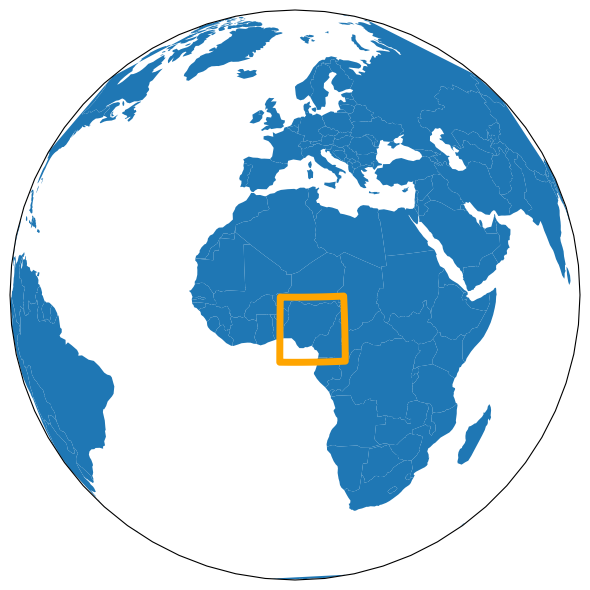

In [16]:
%matplotlib inline
cells = cutout.grid.buffer(0.01)
df = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_bound = gpd.GeoSeries(cells.unary_union)

projection = ccrs.Orthographic(5, 15)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(
    ax=ax, edgecolor="orange", linewidth=5, facecolor="None", transform=plate()
)
fig.tight_layout()

# plt.savefig("cutout-earthplot-nigeria.pdf", bbox_inches='tight')

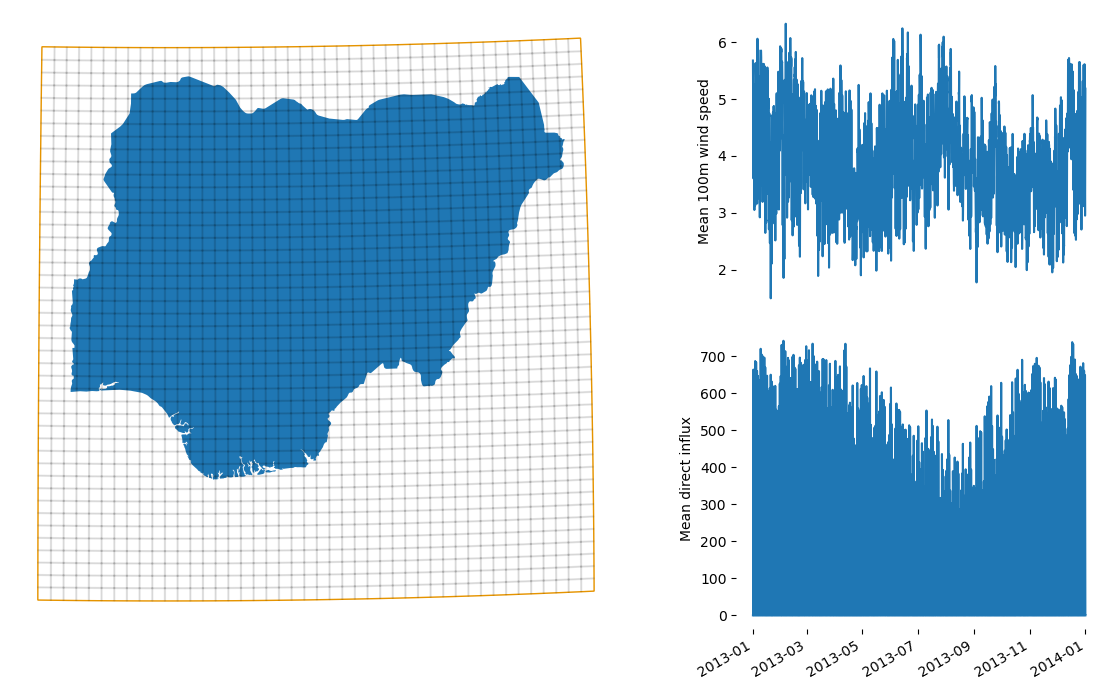

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
NG.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
ax.outline_patch.set_edgecolor("white")

ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.set_ylabel("Mean 100m wind speed")
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(["x", "y"]).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.set_xlabel(None)
ax2.set_ylabel("Mean direct influx")
fig.tight_layout()

# plt.savefig("onshore-capacity-factor.pdf", bbox_inches='tight')

INFO:atlite.convert:Convert and aggregate 'wind'.


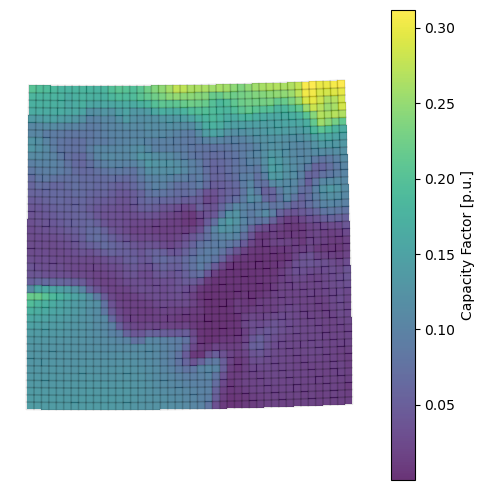

In [18]:
%matplotlib inline
cap_factors = cutout.wind(turbine="Vestas_V112_3MW", capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(5, 5))
cap_factors.name = "Capacity Factor"
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
ax.outline_patch.set_edgecolor("white")
fig.tight_layout();

# plt.savefig("onshore-capacity-factor-nigeria.pdf", bbox_inches='tight')